In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 使用CNN实现手写数字识别

参考资料：
https://blog.csdn.net/weixin_42970026/article/details/83069376
https://www.bilibili.com/video/BV1Dm4y1U768?p=38
https://zhuanlan.zhihu.com/p/48595579

实现过程：
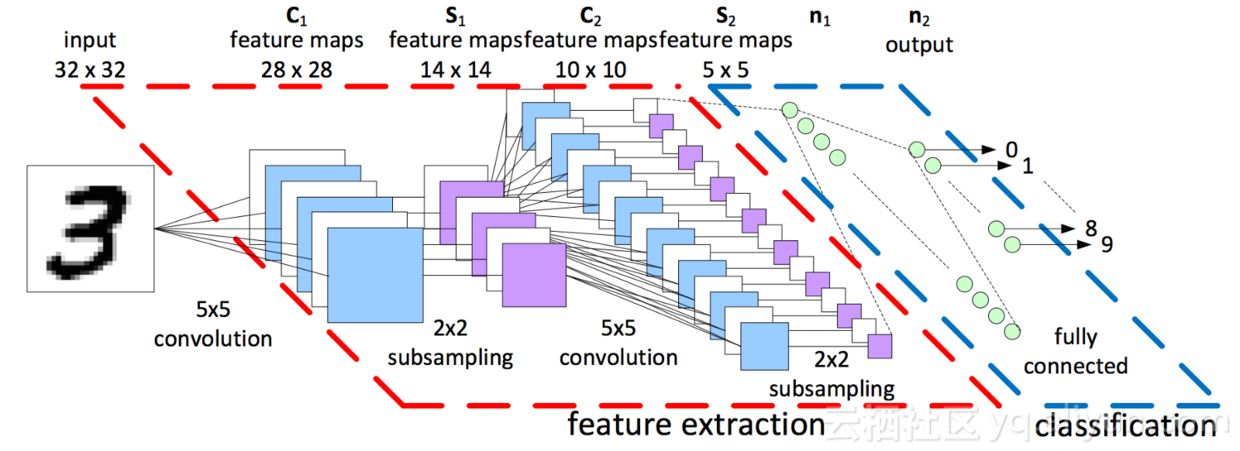

### 数据下载和处理（和非cnn的那个一样）

In [2]:
!pip install --upgrade pip numpy
#安装需要的numpy版本

     |████████████████████████████████| 2.1 MB 929 kB/s            
     |████████████████████████████████| 15.7 MB 62.7 MB/s            
  Attempting uninstall: pip
    Found existing installation: pip 21.3.1
    Uninstalling pip-21.3.1:
      Successfully uninstalled pip-21.3.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
beatrix-jupyterlab 3.1.6 requires google-cloud-bigquery-storage, which is not installed.
thinc 8.0.15 requires typing-extensions<4.0.0.0,>=3.7.4.1; python_versi

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
 
import torchvision.datasets as dsets
import torchvision.transforms as transforms
 
import matplotlib.pyplot as plt
import numpy as np
 
%matplotlib inline
 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.enabled = True
 
# 超参数
image_size = 28 # 图像分辨率28*28
num_classes = 10
num_epochs = 60
num_workers = 2
batch_size = 128
 
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.Compose([transforms.ToTensor(),
                                                          transforms.RandomHorizontalFlip(), # 图像的一半概率翻转，一半不翻
                                                          transforms.Normalize(mean=0.5, std=0.5)
                                                         ]), 
                            download=True)
test_dataset = dsets.MNIST(root='./data',
                           train=False, 
                           transform=transforms.Compose([transforms.ToTensor(),
                                                          transforms.Normalize(mean=0.5, std=0.5)
                                                         ]),
                          download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
 
# 测试数据分成两部分，一部分作为校验数据，一部分作为测试数据
indices = range(len(test_dataset))
indices_val = indices[:4000] # 校验集
indices_test = indices[4000:] # 测试集
 
# 采样器随机从原始数据集中抽样数据，生成任意一个下标重排，从而利用下标来提取数据集中数据
sampler_val = torch.utils.data.sampler.SubsetRandomSampler(indices_val)
sampler_test = torch.utils.data.sampler.SubsetRandomSampler(indices_test)
val_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, sampler=sampler_val, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, sampler=sampler_test, num_workers=num_workers)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:174.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### 定义网络

In [4]:
class ConvNet(nn.Module):
    # 构造函数，每当类ConvNet被具体化一个实例时就会被调用
    def __init__(self):
        super(ConvNet, self).__init__()#定义网络
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1, stride=1, bias=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=1, stride=1, bias=True)
        self.fc1 = nn.Linear(image_size // 4 * image_size // 4 * 8, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(self.pool(x)))
        x = self.pool(x)
        x = x.view(-1, image_size // 4 * image_size // 4 * 8)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training, p=0.4) # 40%的比例随机失活神经元，减少过拟合
        x = F.log_softmax(self.fc2(x), dim=1)
        return x
    
    # 提取特征图，返回前两层卷积层的特征图
    def retrieve_features(self, x):
        feature_map1 = F.relu(self.conv1(x))
        x = self.pool(feature_map1)
        feature_map2 = F.relu(self.conv2(x))
        return (feature_map1, feature_map2)

### 训练

In [5]:
net = ConvNet()
# 采用多GPU训练
if torch.cuda.device_count() > 1:
    net = nn.DataParallel(net, device_ids=[0, 1])
net.to(device)
print(net)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=net.parameters(), lr=0.0001)
 
record = [] # 记录准确率等数值
weights = [] # 每若干步就记录一次卷积核
 
def rightness(output, target):
    # torch.max函数返回输入张量给定维度上每行的最大值，并同时返回每个最大值的位置索引
    preds = output.data.max(dim=1, keepdim=True)[1] # keepdim保持输出的维度
    return preds.eq(target.data.view_as(preds)).sum(), len(target) # 返回数值为：（正确样例数，总样本数）
 
best_acc = 0.0 # 最优准确率
best_epoch = 0 # 最优轮次
save_path = './ConvNet.pth'
for epoch in range(num_epochs):
    # 训练
    train_rights = [] # 每轮次训练得到的准确数量
    net.train() # 把所有的dropout层打开
    # enumerate起到枚举器的作用，在train_loader循环时，枚举器会自动输出一个数字指示循环的次数，并记录在batch_idx中
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target) # data：手写数字图像，target：该图像对应标签
        output = net(data.to(device))
        loss = criterion(output, target.to(device))
        optimizer.zero_grad() # 清空所有被优化变量的梯度信息
        loss.backward()
        optimizer.step() # 进行单次优化，更新所有的参数
        train_rights.append(rightness(output, target.to(device)))
        
    # 校验
    net.eval() # 把所有的dropout层关闭
    val_rights = [] # 每轮次校验得到的准确数量
    with torch.no_grad():
        for (data, target) in val_loader:
            data, target = Variable(data), Variable(target)
            output = net(data.to(device))
            val_rights.append(rightness(output, target.to(device)))
 
    train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
    val_r = (sum([tup[0] for tup in val_rights]), sum([tup[1] for tup in val_rights]))
    train_acc = 1.0 * train_r[0] / train_r[1]
    val_acc = 1.0 * val_r[0] / val_r[1]
    if val_acc > best_acc:
        best_acc = val_acc
        best_epoch = epoch + 1
        torch.save(net.state_dict(), save_path)
    print("[epoch {}] loss:{:.6f}，train_acc：{:.2f}%，val_acc：{:.2f}%".format(
        epoch + 1, loss.item(),
        100 * train_acc, 100 * val_acc
    ))
    record.append((1 - train_acc, 1- val_acc))
    weights.append([net.conv1.weight.data.clone(), net.conv1.bias.data.clone(), 
                    net.conv2.weight.data.clone(), net.conv2.bias.data.clone()])
print("best epoch: %d，best val_acc: %.2f" %(best_epoch, best_acc * 100))

ConvNet(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=392, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)
[epoch 1] loss:0.954204，train_acc：55.37%，val_acc：75.03%
[epoch 2] loss:0.622807，train_acc：79.17%，val_acc：80.38%
[epoch 3] loss:0.643709，train_acc：83.19%，val_acc：82.23%
[epoch 4] loss:0.280229，train_acc：85.45%，val_acc：84.43%
[epoch 5] loss:0.315259，train_acc：87.08%，val_acc：85.33%
[epoch 6] loss:0.280199，train_acc：88.40%，val_acc：87.15%
[epoch 7] loss:0.373988，train_acc：89.75%，val_acc：88.73%
[epoch 8] loss:0.328736，train_acc：90.87%，val_acc：89.98%
[epoch 9] loss:0.183748，train_acc：91.86%，val_acc：91.13%
[epoch 10] loss:0.280434，train_acc：92.53%，val_acc：92.25%
[epoch 11] loss:0.157707，train_acc：93.17%，val_acc：92.50%
[epoch 12] lo

### 测试准确度

In [6]:
net= ConvNet()
net.load_state_dict({k.replace('module.',''):v for k,v in torch.load(save_path).items()})
net.to(device)
net.eval()
test_rights = []
for data, target in test_loader:
    data, target = Variable(data, requires_grad=False), Variable(target)
    output = net(data.to(device))
    test_rights.append(rightness(output, target.to(device)))
 
test_r = (sum(tup[0] for tup in test_rights), sum(tup[1] for tup in test_rights))
test_acc = 1.0 * test_r[0] / test_r[1]
print("test_acc:%.2f%%" %(test_acc * 100))

test_acc:98.93%


准确度为98.40%

### 输出误差曲线

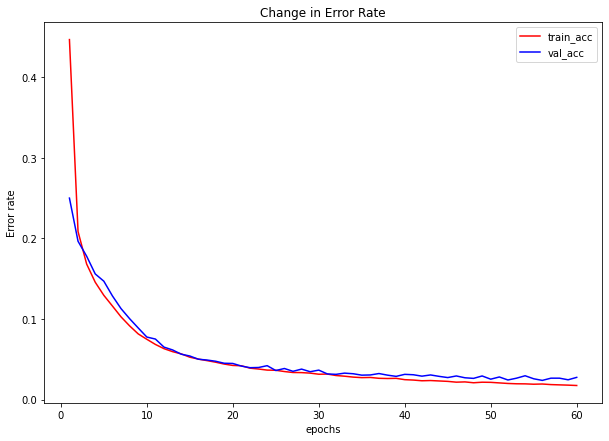

In [7]:
train_err_y = [y[0].cpu() for y in record]#要先转换到cpu
val_err_y = [y[1].cpu() for y in record]
def Show_ErrorRate():
    plt.figure(figsize = (10, 7))
    x=range(1, num_epochs + 1)
    plt.title("Change in Error Rate")
    plt.plot(x, train_err_y, color='red', label='train_acc')
    plt.plot(x, val_err_y, color='blue', label='val_acc')
    plt.legend() # 显示图例
    plt.xlabel('epochs')
    plt.ylabel('Error rate')
    
Show_ErrorRate()